In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import scipy.stats as sps
import matplotlib.pyplot as plt
import plotly.graph_objs as go

### Constants:

In [2]:
ALPHA = 0.05
BETA = 0.2

PRE_START = pd.to_datetime('2023-04-01', format='%Y-%m-%d')
PRE_END = pd.to_datetime('2023-04-30', format='%Y-%m-%d')
EXP_START = pd.to_datetime('2023-05-01', format='%Y-%m-%d')
EXP_END = pd.to_datetime('2023-05-31', format='%Y-%m-%d')

In [3]:
pd.to_datetime(1653285343, unit='s') <= pd.to_datetime('2022-05-23', format='%Y-%m-%d')

False

### Read file:

In [4]:
df = pd.read_csv("ab_made_4.gzip", compression='gzip')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') + timedelta(hours=3)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [5]:
df.sample(5)

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date
32699,2023-05-19 23:06:55,user_564,0,A,Москва,19.0,0,2023-05-19
32725,2023-05-19 14:50:49,user_10368,0,A,Ярославь,2.0,0,2023-05-19
20836,2023-04-29 12:33:28,user_7782,12,NaN,Рязань,7.0,1,2023-04-29
21057,2023-04-29 01:23:54,user_973,0,NaN,Рязань,17.0,0,2023-04-29
7153,2023-04-20 06:53:16,user_8329,0,NaN,Тула,4.0,0,2023-04-20


In [6]:
pre_group_df = df[df['group'].isna()]
a_group_df = df[df['group'] == 'A']
b_group_df = df[df['group'] == 'B']

In [7]:
print(
    f"Даты pre-периода лежат в промежутке с {pre_group_df['date'].min()} по {pre_group_df['date'].max()}"
)
print(
    f"Даты A-группы лежат в промежутке с {a_group_df['date'].min()} по {a_group_df['date'].max()}"
)
print(
    f"Даты B-группы лежат в промежутке с {b_group_df['date'].min()} по {b_group_df['date'].max()}"
)

Даты pre-периода лежат в промежутке с 2023-04-01 00:00:00 по 2023-04-30 00:00:00
Даты A-группы лежат в промежутке с 2023-05-01 00:00:00 по 2023-05-31 00:00:00
Даты B-группы лежат в промежутке с 2023-05-01 00:00:00 по 2023-05-31 00:00:00


In [8]:
print(f"Кол-во пользователей для pre-периода равно {pre_group_df['id_user'].nunique()}")
print(f"Кол-во пользователей для A-группы равно {a_group_df['id_user'].nunique()}")
print(f"Кол-во пользователей для B-группы равно {b_group_df['id_user'].nunique()}")

Кол-во пользователей для pre-периода равно 10000
Кол-во пользователей для A-группы равно 6000
Кол-во пользователей для B-группы равно 6000


In [9]:
print(f"Кол-во событий для pre-периода равно {pre_group_df['id_user'].count()}")
print(f"Кол-во событий для A-группы равно {a_group_df['id_user'].count()}")
print(f"Кол-во событий для B-группы равно {b_group_df['id_user'].count()}")

Кол-во событий для pre-периода равно 25759
Кол-во событий для A-группы равно 15389
Кол-во событий для B-группы равно 15257


### Посмотрим на выбросы и попробуем заменить их на значение выбранного верхнего перцентиля, то есть, грубо говоря, ограничить значение:

In [10]:
threshold = 0.01

#### Pre-group:

In [11]:
# сначала посмотрим на выбросы, которые кажутся прямо таки аномальными
lower_bound = pre_group_df.sum_payment.quantile(q=threshold)
upper_bound = pre_group_df.sum_payment.quantile(q=1-threshold)
emission_df = pre_group_df[
    (pre_group_df.sum_payment < lower_bound) | (pre_group_df.sum_payment > upper_bound)
]

In [12]:
pre_group_df.loc[
    pre_group_df.index.isin(emission_df.index), "sum_payment"
] = pre_group_df.loc[pre_group_df.index.isin(emission_df.index), "sum_payment"].apply(
    lambda x: min(x, upper_bound)
)

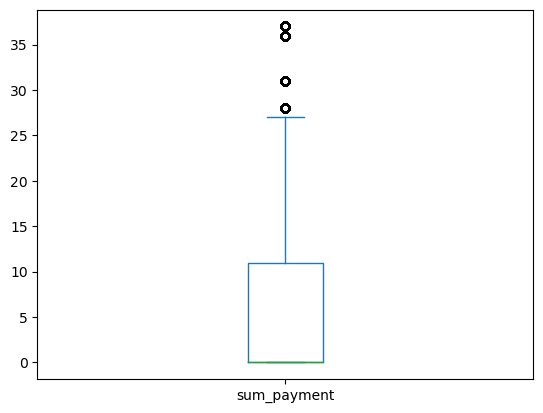

In [13]:
_, bp = pre_group_df.sum_payment.plot.box(return_type='both')

### Рассчитаем длительность:

In [14]:
def metric(df, ending, exp=False):
    filter_df = df.groupby('id_user').timestamp.min().reset_index(name='min_timestamp')
    filter_df['max_timestamp'] = filter_df['min_timestamp'] + timedelta(seconds=7 * 24 * 60 * 60)
    df2 = df.merge(filter_df, on='id_user')
    df2 = df2[(df2['timestamp'] <= df2['max_timestamp']) & (df2['timestamp'] >= df2['min_timestamp'])]
    df2 = df2[pd.to_datetime(df2['max_timestamp']).dt.normalize() <= ending]
    
    return df2.groupby('id_user').sum_payment.sum().tolist()

In [15]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=ALPHA, beta=BETA):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

In [16]:
sigma_1 = sigma_2 = np.std(metric(pre_group_df, ending=PRE_END))

mean_base = np.mean(metric(pre_group_df, ending=PRE_END))
effect = 0.1 * mean_base

k = a_group_df['id_user'].nunique() / b_group_df['id_user'].nunique()

In [17]:
target_n = int(duration(k, effect, sigma_1, sigma_2, alpha=0.05, beta=0.2)/2)

In [18]:
print(f"Достаточное количество юзеров с законченным окном в каждой группе: {target_n}")

Достаточное количество юзеров с законченным окном в каждой группе: 3570


### Фильтранем даты:

In [19]:
#  def filtering_dataframe(df, target_n):
#     filtering_df = df.groupby('date').size().reset_index(name='events') 
#     filtering_df['cumsum'] = filtering_df['events'].cumsum()
#     date = filtering_df.loc[
#     filtering_df["cumsum"] >= target_n, "date"
# ].min()
#     return date

def filtering_dataframe(df, target_n):
    """По дням смотрим кол-во юзеров, у которых закончилось окно в 7 дней
       Стоит сразу дождаться недели эксперимента, чтобы закрылось окно у юзеров первого дня"""
    #start_date = pd.Timestamp(EXP_START, unit='s')
    date = EXP_START + timedelta(days=7) 
    while True:
        if date == EXP_END:
            return date
        temp_df = df[df['date'] <= date]
        filter_df = temp_df.groupby('id_user').timestamp.min().reset_index(name='min_timestamp')
        filter_df['max_timestamp'] = filter_df['min_timestamp'] + timedelta(seconds=7 * 24 * 60 * 60)
        filter_df = filter_df[pd.to_datetime(filter_df['max_timestamp']).dt.normalize() <= date]
        if filter_df.id_user.nunique() >= target_n:
            return date
        date = date + timedelta(days=1)

In [20]:
a_date = filtering_dataframe(a_group_df, target_n)

In [21]:
a_date = filtering_dataframe(a_group_df, target_n)
b_date = filtering_dataframe(b_group_df, target_n)

if a_date == b_date:
    EXP_END = a_date
else:
    EXP_END = max(a_date, b_date)

In [22]:
print(f"Дата окончания: {EXP_END}")

Дата окончания: 2023-05-31 00:00:00


In [23]:
a_group_new_df =  a_group_df[a_group_df['date'] <= EXP_END]
b_group_new_df =  b_group_df[b_group_df['date'] <= EXP_END]

In [24]:
assert a_group_df.date.max() == EXP_END
assert b_group_df.date.max() == EXP_END
assert a_group_df['timestamp'].max().normalize() == EXP_END
assert b_group_df['timestamp'].max().normalize() == EXP_END

### Посмотрим на выбросы в полученных группах, почистим их:

#### A-group:

In [25]:
# сначала посмотрим на выбросы, которые кажутся прямо таки аномальными
lower_bound = a_group_new_df.sum_payment.quantile(q=threshold)
upper_bound = a_group_new_df.sum_payment.quantile(q=1-threshold)
emission_df = a_group_new_df[
    (a_group_new_df.sum_payment < lower_bound) | (a_group_new_df.sum_payment > upper_bound)
]

In [26]:
a_group_new_df.loc[
    a_group_new_df.index.isin(emission_df.index), "sum_payment"
] = a_group_new_df.loc[a_group_new_df.index.isin(emission_df.index), "sum_payment"].apply(
    lambda x: min(x, upper_bound)
)

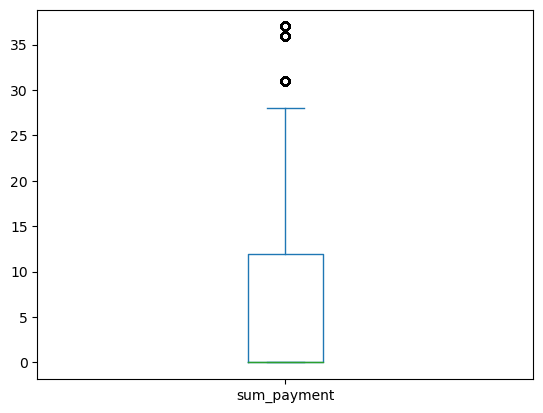

In [27]:
_, bp = a_group_new_df.sum_payment.plot.box(return_type='both')

#### B-group:

In [28]:
# сначала посмотрим на выбросы, которые кажутся прямо таки аномальными
lower_bound = b_group_new_df.sum_payment.quantile(q=threshold)
upper_bound = b_group_new_df.sum_payment.quantile(q=1-threshold)
emission_df = b_group_new_df[
    (b_group_new_df.sum_payment < lower_bound) | (b_group_new_df.sum_payment > upper_bound)
]

In [29]:
b_group_new_df.loc[
    b_group_new_df.index.isin(emission_df.index), "sum_payment"
] = b_group_new_df.loc[b_group_new_df.index.isin(emission_df.index), "sum_payment"].apply(
    lambda x: min(x, upper_bound)
)

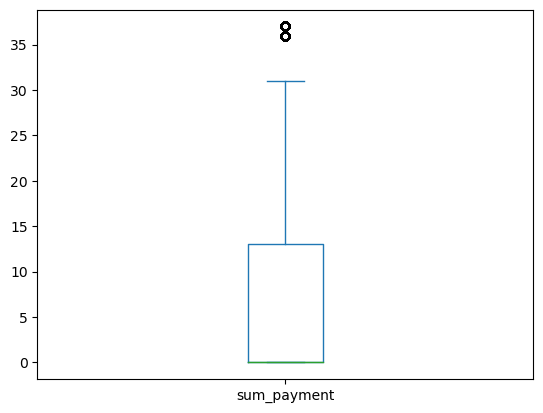

In [30]:
_, bp = b_group_new_df.sum_payment.plot.box(return_type='both')

### Анализ эксперимента:

In [31]:
def dynamic_metric(a_df, b_df):
    final_df = pd.DataFrame(
        [],
        columns=["metric_a", "metric_b", "effect", "t", "p_value"],
        index=pd.date_range(EXP_START + timedelta(days=7), EXP_END),
    )
    for date in final_df.index:
        tmp_a = metric(a_df[a_df["date"] <= date], ending=date, exp=True)
        tmp_b = metric(b_df[b_df["date"] <= date], ending=date, exp=True)
        effect = np.mean(tmp_b) - np.mean(tmp_a)
        results = sps.ttest_ind(tmp_a, tmp_b, equal_var=abs(np.var(tmp_b) - np.var(tmp_a)) <= 0.1)
        t, p_value = results.statistic, results.pvalue
        final_df.loc[date] = np.mean(tmp_a), np.mean(tmp_b), effect, t, p_value
    return final_df

In [32]:
results = dynamic_metric(a_group_new_df, b_group_new_df)

### Посмотрим на финальные результаты:

In [33]:
results.tail(1)

,metric_a,metric_b,effect,t,p_value
2023-05-31,11.281241,12.69074,1.409499,-3.368989,0.000759


### Посмотрим данные в динамике:

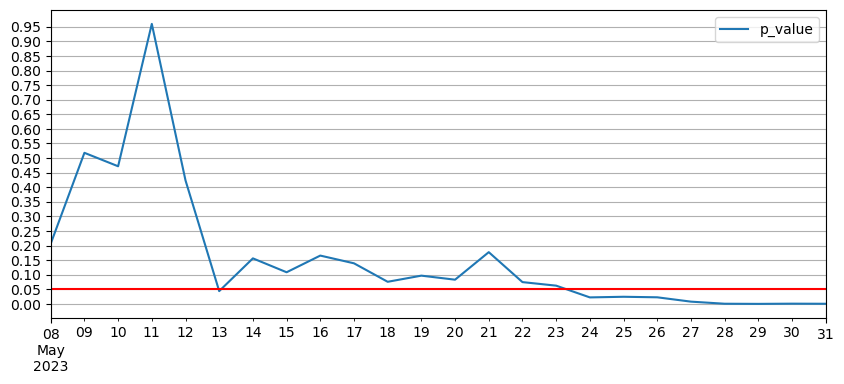

In [34]:
results.plot(y='p_value', figsize=(10, 4), grid=True, yticks=np.arange(0, 1, 0.05))
plt.plot(results.index, [ALPHA] * len(results.index), color='red')
plt.show()

#### Итоговое решение:

In [40]:
print(f"Решение - выигрыш достается группе: {'B' if results.tail(1)['p_value'].values[0] <= ALPHA else 'A'}")

Решение - выигрыш достается группе: B
